In [210]:
import sklearn
from sklearn.datasets import load_boston, load_diabetes
import tensorflow.compat.v2 as tf
import tensorflow.keras as keras
import sys
import matplotlib.pyplot as plt
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Tuple
from num2words import num2words
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

sys.path.insert(0,' ../')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Load data

In [2]:


mnist = MNIST('../data')
x_train, y_train = mnist.load_training() #60,000 samples
x_test, y_test = mnist.load_testing()    #10,000 samples

In [3]:
x_train_img = [np.asarray(x_train).astype(np.float32)[i].reshape(28,28,1) for i in range(3)]


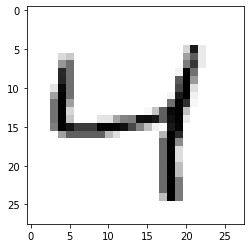

In [4]:
plt.imshow(x_train_img[2], cmap='Greys')

In [5]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
x_test =  np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

# Primitive functions


### Sin

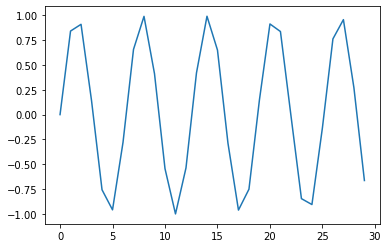

In [6]:
plt.plot(np.sin(np.arange(0,30)))

### Cosin

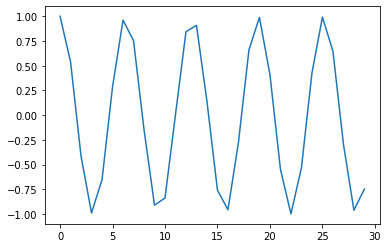

In [7]:
plt.plot(np.cos(np.arange(0,30)))

#### sqrt

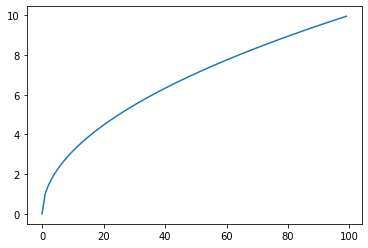

In [8]:
plt.plot(np.sqrt(np.arange(0,100)))

### log

<ipython-input-9-b3cb4314f8db>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(0,100)))


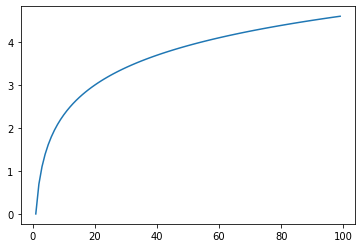

In [9]:
plt.plot(np.log(np.arange(0,100)))

In [100]:
t = np.array([1,2,3,4,5,6])

In [101]:
ids = np.arange(len(t))//4

In [102]:
ids

array([0, 0, 0, 0, 1, 1])

In [109]:
for i in range(0,len(t),4):
    print(t[i:i+4])

[1 2 3 4]
[5 6]


In [140]:
class MathFunctions():
    def __init__(self,weight):
        """weight is the parameter applied to all functions"""
        self.weight = weight

    def mf_sum(self, input_data):
       return  self.__x_number_sum(input_data)

    def mf_running_avg(self, input_data):
       return  self.__x_number_average(input_data)
    
    def mf_discrete_avg(self, input_data):

        ids = np.arange(len(input_data))//self.weight
        return np.bincount(ids,input_data)/np.bincount(ids)
    
    def mf_max_pool(self, input_data):
        new_max = []
        if type(input_data) == list:
            input_data = np.array(input_data)
            
        for i in range(0,len(input_data),self.weight):
            new_max.append(np.max(input_data[i:i+self.weight]))
        
        return new_max
        
        
    
    def mf_pow(self, input_data):
        return  np.power(input_data, self.weight)
    
    def mf_linear_transform(self, input_data):
        return input_data*self.weight + self.weight
    

    def __x_number_average(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)

        weight = self.weight
        if len(input_data) <= weight:
            return np.mean(input_data)

        len_ = len(input_data)
        new_data = []
        previous_row = 0
        for i in range(weight, len_+1):
            new_data.extend(
                [
                    np.mean(
                        input_data[previous_row: i]
                        )
                    ]
                )
            previous_row+=1
        return np.array(new_data)

    def __x_number_sum(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)

        weight = self.weight
        if len(input_data) <= weight:
            return np.sum(input_data)

        len_ = len(input_data)
        new_data = []
        previous_row = 0
        for i in range(weight, len_+1):
            new_data.extend([np.sum(input_data[previous_row: i])])
            previous_row += i
        return np.array(new_data)

        
        

    

In [141]:
custom_math_functions= MathFunctions(4)

In [142]:
assert custom_math_functions.mf_running_avg([10,10,20,20,10]).all() == np.array([15,15]).all()
assert custom_math_functions.mf_sum([10,10]) == [20]
assert custom_math_functions.mf_pow([10]) == [10000]

In [143]:
custom_math_functions.mf_discrete_avg([10,10,20,20,10]) 

array([15., 10.])

In [144]:
custom_math_functions.mf_max_pool([1,2,3,4,3,2,4])

[4, 4]

In [128]:
custom_math_functions.mf_sum([10,10,10,10,10,10])  # no overlap in the numbers

array([40, 10,  0])

In [129]:
custom_math_functions.mf_pow([10,10,10,10,10,10])  # no overlap in the numbers

array([10000, 10000, 10000, 10000, 10000, 10000])

# Define a non NN model

In [390]:
class RandomModelArchitecture():
    
    def __init__(self, n_pixel_to_process, primitive_functions, math_function_class):
        self.math_function_class = math_function_class
        self.primitive_functions = primitive_functions
        self.n_pixel_to_process = n_pixel_to_process
        
    def set_rmse(self, rmse):
        self.rmse = rmse
        
    def get_random_architecture(self, input_image):
        """
        Return a list of strings corresponds to a model architecture for the given 
        """
        model_architecture = []
        while len(input_image) !=0:

            #pick the number to apply
            function_n = np.random.randint(len(self.primitive_functions))
            math_function_str = self.primitive_functions[function_n]
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)
            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)

            model_architecture.append(math_function_str)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            try:
                input_image[input_image == -np.inf] = 0
            except Exception as e:
                print(e)
                print(input_image)
            if  type(input_image) == numpy.float64:
                break
            elif len(input_image) <= self.n_pixel_to_process: #Largest consolidation function
                break
        self.model_architecture = model_architecture

        return model_architecture

    def get_prediction_from_architecture(self, input_image):
        
        n_functions = len(self.model_architecture)
        for idx, math_function_str in enumerate(self.model_architecture):

            if  n_functions == idx+1: #Largest consolidation function

                # For now, just take the  mean of the last elements
                final_prediction = np.mean(input_image) 
                if np.isinf(final_prediction):
                    final_prediction = 0
                return final_prediction

            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)

            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            input_image[input_image == -np.inf] = 0

    def agument_existing_architecture_list(self, input_image):
        """,
        For our genetic algorithm, given a list of architectures, keep the first half and randomly generate the second half
        """
        n_functions_in_architecture = len(self.model_architecture)


        if type(architecture_list) == list:
            self.model_architecture = np.array(self.model_architecture)
        new_architecture_list = list(self.model_architecture[:n_functions_in_architecture//2])

        for math_function_str in new_architecture_list:
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)

            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            input_image[input_image == -np.inf] = 0

        # Now, randomly generate the second half of the arhictecture
        while len(input_image) !=0:

            #pick the number to apply
            function_n = np.random.randint(len(self.primitive_functions))
            math_function_str = self.primitive_functions[function_n]
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)
            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)

            new_architecture_list.append(math_function_str)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            try:
                input_image[input_image == -np.inf] = 0
            except Exception as e:
                print(e)
                print(input_image)
                
            if  type(input_image) == numpy.float64 or type(input_image) == numpy.float32:
                final_prediction = input_image
                break
            elif len(input_image) <= self.n_pixel_to_process: #Largest consolidation function
                # For now, just take the  mean of the last elements
                final_prediction = np.mean(input_image) 
                if np.isinf(final_prediction):
                    final_prediction = 0
                predictions.append(final_prediction)
                break
        self.model_architecture = np.array(new_architecture_list)

    
    

In [391]:
# def get_random_architecture(input_image,  n_pixel_to_process, primitive_functions, math_function_class):
#     """
#     Return a list of strings corresponds to a model architecture for the given 
#     """
#     model_architecture = []
#     while len(input_image) !=0:
#         if  len(input_image) <= n_pixel_to_process: #Largest consolidation function
#             break

#         #pick the number to apply
#         function_n = np.random.randint(len(primitive_functions))
#         math_function_str = primitive_functions[function_n]
#         if 'mf' in math_function_str:
#             function_module = getattr(math_function_class, math_function_str)
#         else:
#             function_module = getattr(numpy, math_function_str)
#         # Transform the image with the corresponding primitive function choosen
#         input_image = function_module(input_image)

#         model_architecture.append(math_function_str)
#         # housekeeping in case our primitive functions go wonky
#         input_image = np.nan_to_num(input_image)
#         try:
#             input_image[input_image == -np.inf] = 0
#         except Exception as e:
#             print(e)
#             print(input_image)

#     return model_architecture

In [392]:
FINAL_MODEL_RMSE

[]

In [393]:
np.argsort(FINAL_MODEL_RMSE)[0][:25] 

IndexError: index 0 is out of bounds for axis 0 with size 0

In [394]:
len(np.argsort(FINAL_MODEL_RMSE[0])) // 2

IndexError: list index out of range

In [395]:
np.array(FINAL_MODEL_ARCHITECTURES)[np.argsort(FINAL_MODEL_RMSE)[0][:2]]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [398]:
PRIMITIVE_FUNCTIONS_LIST = [ 'log', 'cos', 'sin','mf_sum', 'mf_running_avg', 'mf_pow', 'mf_linear_transform', 'mf_discrete_avg', 'mf_max_pool']
FINAL_MODEL_CLASSES = []  # RMA classes
AVG_RMSE_PER_GENERATION = []
FINAL_MODEL_RMSE = []
NUM_IMAGES_PER_ARCHITECTURE = 10
NUM_ARCHITECTURES = 10
N_GENERATIONS = 2
SAMPLE_IMAGE = x_train[0,...].copy()
custom_math_functions = MathFunctions(RANDOM_WEIGHT)


for gen in range(N_GENERATIONS):
    print(f"Generation {gen+1}")
    # New architecture

    gen_rmse = []
    gen_models = []
    for _ in tqdm(range(NUM_ARCHITECTURES)):

        # new image
        all_predictions=[]
        all_y_labels=[]

        RANDOM_WEIGHT = np.random.randint(2,20)
        rma = RandomModelArchitecture(RANDOM_WEIGHT, PRIMITIVE_FUNCTIONS_LIST, custom_math_functions)
        model_architecture = rma.get_random_architecture( SAMPLE_IMAGE )
        gen_models.append(rma)

        for img_idx, img in enumerate(x_train[0:NUM_IMAGES_PER_ARCHITECTURE,...]):
            y_true = y_train[img_idx]
            all_y_labels.append(y_true)

            prediction = rma.get_prediction_from_architecture(img.copy())
            all_predictions.append(prediction)


        gen_rmse.append(np.sqrt(mean_squared_error(all_y_labels, all_predictions)))
        rma.set_rmse(np.sqrt(mean_squared_error(all_y_labels, all_predictions)))
        
    if type(gen_rmse) == list:
        gen_rmse = np.array(gen_rmse)
    gen_rmse[gen_rmse == np.inf] = 999999
    FINAL_MODEL_RMSE.append(gen_rmse)
    FINAL_MODEL_CLASSES.append(gen_models)
    
    print(f"Generation {gen+1} average rmse = {np.mean(FINAL_MODEL_RMSE[gen])}")
    
    # take top 5% of architectures we've generated
    top_architectures_rmse_argsort = np.argsort(FINAL_MODEL_RMSE[gen])
    top_half_architecture  = len(np.argsort(top_architectures_rmse_argsort)) // 2
    
    top_architectures_rmse_argsort[:top_half_architecture]
    

    best_architectures = np.array(FINAL_MODEL_CLASSES[gen])[top_architectures_rmse_argsort[:top_half_architecture]]
    
    for rma_class in best_architectures:
        print(f"Original predictions {rma_class.get_prediction_from_architecture(SAMPLE_IMAGE)}")
        rma_class.agument_existing_architecture_list(SAMPLE_IMAGE)
        rma_class.get_prediction_from_architecture(SAMPLE_IMAGE)
        print(f" New prediction {rma_class.get_prediction_from_architecture(SAMPLE_IMAGE)}")
    
    


        



 20%|██        | 2/10 [00:00<00:00, 10.98it/s]

Generation 1


100%|██████████| 10/10 [00:00<00:00, 12.39it/s]


'numpy.float64' object does not support item assignment
7.7068854020650335
Generation 1 average rmse = 5.11970781503694
Original predictions 2.225548930882714
 New prediction 4967.384615384615
Original predictions 1.2844809003441722
 New prediction 0.9748225808143616
Original predictions 0.9894335310704983
 New prediction 0.0
Original predictions 0.8773613420052275
 New prediction 0.38698155995608335
Original predictions 0.6937291979217642


 40%|████      | 4/10 [00:00<00:00, 27.31it/s]

 New prediction 1.0
Generation 2
'numpy.float64' object does not support item assignment
4.678882266279772e+38


100%|██████████| 10/10 [00:00<00:00, 20.46it/s]

Generation 2 average rmse = 7.491107114945845e+37
Original predictions 2.0048203468322754
 New prediction -0.015589289367198944
Original predictions 0.6577816616532886
 New prediction 8.000033592942087
Original predictions 0.06523783676899396
 New prediction 7.951547077363504
Original predictions 0.0
'numpy.float32' object does not support item assignment
3.7483335
 New prediction 0.749666690826416
Original predictions 0
 New prediction 1.1845097541809082


In [397]:
RANDOM_WEIGHT

8

In [297]:
custom_math_functions.mf_discrete_avg(np.cos(x_train[0,...]))

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.49055745, 0.65858265,
       0.35346029, 0.41254273, 0.84671188, 0.47662001, 0.50016899,
       1.        , 0.67384828, 0.7925838 , 1.        , 0.81124645,
       0.80426464, 0.79486122, 0.82327278, 1.        , 0.66281803,
       0.72864066, 1.        , 0.71762846, 0.76691359, 0.85684856,
       0.51640539, 0.73348082, 0.83548134, 0.34632194, 0.66984189,
       0.83213792, 0.4940607 , 0.44833194, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [232]:
x_train[0,...]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [195]:
FINAL_MODEL_ARCHITECTURES

[['mf_linear_transform',
  'log',
  'mf_sum',
  'log',
  'mf_linear_transform',
  'mf_sum',
  'mf_pow',
  'log',
  'mf_sum'],
 ['mf_avg', 'log', 'mf_linear_transform', 'mf_pow', 'mf_avg'],
 ['log',
  'mf_sum',
  'mf_linear_transform',
  'mf_sum',
  'cos',
  'cos',
  'cos',
  'mf_linear_transform',
  'mf_pow',
  'log',
  'cos',
  'mf_pow',
  'cos',
  'mf_linear_transform',
  'log',
  'sin',
  'mf_avg'],
 ['log',
  'log',
  'sin',
  'log',
  'mf_linear_transform',
  'mf_pow',
  'cos',
  'log',
  'mf_linear_transform',
  'mf_sum'],
 ['cos', 'mf_pow', 'cos', 'log', 'mf_avg'],
 ['log', 'mf_pow', 'sin', 'log', 'cos', 'mf_linear_transform', 'mf_avg'],
 ['mf_linear_transform',
  'mf_avg',
  'mf_sum',
  'mf_sum',
  'sin',
  'cos',
  'sin',
  'sin',
  'sin',
  'mf_avg',
  'cos',
  'mf_sum',
  'mf_sum',
  'mf_pow',
  'mf_avg'],
 ['mf_avg',
  'sin',
  'mf_linear_transform',
  'mf_sum',
  'mf_linear_transform',
  'mf_avg',
  'sin',
  'mf_avg',
  'sin',
  'sin',
  'mf_sum',
  'mf_sum',
  'sin',
  'm

In [165]:
custom_math_functions.mf_pow( list(np.log(custom_math_functions.mf_avg(test_array))))

array([128.93997166, 162.35323938, 162.35323938, 162.35323938])

In [166]:
np.log(custom_math_functions.mf_avg(test_array))

array([ 5.05199048,  5.45532112,  5.45532112,  5.45532112,  5.45532112,
        5.09783184,  4.60183128,  4.9102009 ,  7.14598447,  7.88845952,
       11.2976302 , 11.29315538, 11.44397188,  9.70135097,  9.73935949,
        9.7193243 ,  9.70279834, 10.04456747, 18.790751  , 25.90684342,
       25.90684983, 25.90608318, 16.04218732, 15.90971899, 13.57128126,
       13.57038253])

In [136]:
custom_math_functions.mf_pow(np.array([1,2,3]))

array([    1,   512, 19683])

In [134]:
custom_math_functions.mf_avg(np.log(custom_math_functions.mf_avg(test_array)))

array([ 8.35584226,  8.96001347,  9.54168752, 10.01712544, 11.21547463,
       12.83821231, 14.45999054, 16.06373717, 17.66633056, 19.26732632,
       20.85343227, 22.43885573])

In [52]:
custom_math_functions.weight

1

In [51]:
custom_math_functions.mf_avg([1,2,3,4,3,4,])

[1.0, 3.2, 2.0, 3.5, 3.0, 3.6666666666666665, 4.0, 3.5, 3.0, 4.0, 4.0, nan]

In [135]:
MODEL_ARCHITECTURES

['cos',
 'three_number_average',
 'three_number_average',
 'sin',
 'two_number_average',
 'cos',
 'log',
 'four_number_average',
 'log',
 'cos',
 'sin',
 'three_number_average',
 'sin',
 'five_number_average',
 'five_number_average',
 'sin',
 'sin',
 'five_number_average',
 'log',
 'four_number_average',
 'sin',
 'sin',
 'four_number_average']

In [70]:
final_prediction


[nan, nan]

In [50]:
x_train[0,...].shape

(784,)

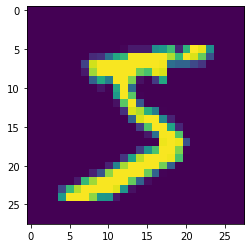

In [33]:
 plt.imshow(x_train[0,...].reshape(28,28,1))

array([100000])

# Define a NN model

In [ ]:
# activations
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)